# Produce Eastern Demand Profile Using EIA Data

In the notebooks loacate in the **spp** and **miso** directories, we produced the following files:
* a file for the hourly load in each sub-area. One profile for SPP which has 16 *legacy BAs* and one profile for MISO which has 6 *Local Resource Zones*.
* a file listing each load bus in our model to a sub-area. One for SPP and one for MISO.

In [1]:
import getpass
import os
import pandas as pd
from powersimdata.input.grid import Grid

from prereise.gather.demanddata.eia.clean_data import fix_dataframe_outliers, replace_with_shifted_demand
from prereise.gather.demanddata.eia.get_eia_data import get_ba_demand
from prereise.gather.demanddata.eia.map_ba import aggregate_ba_demand, get_demand_in_loadzone

## 1. Download Data
Demand data from EIA is imported using an API Key. Note that data for some BAs will not be found and this will be reported.

In [2]:
eastern_ba = [
    'SWPP',
    'MISO',
    'AECI',
    'SPA',
    'EEI',
    'LGEE',
    'OVEC',
    'PJM',
    'NYIS',
    'ISNE',
    'TVA',
    'CPLW',
    'DUK',
    'YAD',
    'CPLE',
    'AEC',
    'SOCO',
    'SEPA',
    'SC',
    'TAL',
    'SCEG',
    'GVL',
    'JEA',
    'SEC',
    'FPC',
    'NSB',
    'TEC',
    'FMPP',
    'FPL',
    'HST']

In [3]:
start = pd.to_datetime('2016-01-01 00:00:00')
end = pd.to_datetime('2016-12-31 23:00:00')

key = getpass.getpass(prompt='api_key=')
eastern_demand = get_ba_demand(eastern_ba, start, end, key)
eastern_demand_2016 = eastern_demand.loc[start:end]
eastern_demand_2016

api_key=········
ERROR: EBA.EEI-ALL.D.H was found but has no data
ERROR: EBA.YAD-ALL.D.H not found. invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/
ERROR: EBA.SEPA-ALL.D.H not found. invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/


,SWPP,MISO,AECI,SPA,LGEE,OVEC,PJM,NYIS,ISNE,TVA,...,SCEG,GVL,JEA,SEC,FPC,NSB,TEC,FMPP,FPL,HST
2016-01-01 00:00:00+00:00,30875.0,78481.0,2917.0,68.0,4280.0,NaN,95072.0,19726,16063.0,18742.0,...,2637.0,270.0,NaN,175.0,7389.0,65.0,2969.0,2507.0,18036.0,84.0
2016-01-01 01:00:00+00:00,31457.0,77902.0,2946.0,83.0,4245.0,NaN,92298.0,19008,15273.0,18555.0,...,2558.0,258.0,NaN,164.0,6931.0,61.0,2778.0,2386.0,16990.0,79.0
2016-01-01 02:00:00+00:00,30969.0,75821.0,2910.0,58.0,4078.0,NaN,89416.0,18340,14568.0,18180.0,...,2487.0,244.0,NaN,152.0,0.0,53.0,2575.0,2226.0,15650.0,73.0
2016-01-01 03:00:00+00:00,30397.0,73863.0,2878.0,80.0,3935.0,NaN,86496.0,17557,13850.0,17744.0,...,2374.0,229.0,NaN,140.0,5830.0,51.0,2397.0,2049.0,14406.0,66.0
2016-01-01 04:00:00+00:00,29818.0,71919.0,2829.0,69.0,3793.0,NaN,83405.0,16772,13108.0,17306.0,...,2256.0,213.0,NaN,128.0,5405.0,48.0,2223.0,1908.0,13389.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00+00:00,26723.0,69959.0,2178.0,70.0,4090.0,80.0,89370.0,17863,14716.0,18673.0,...,2727.0,183.0,1275.0,124.0,5087.0,NaN,2099.0,NaN,12686.0,53.0
2016-12-31 20:00:00+00:00,26109.0,68689.0,2094.0,58.0,4038.0,80.0,90063.0,17847,14714.0,18408.0,...,2676.0,182.0,1234.0,115.0,4998.0,NaN,2047.0,NaN,12760.0,54.0
2016-12-31 21:00:00+00:00,25618.0,68160.0,2035.0,60.0,3957.0,80.0,90826.0,18117,14965.0,18052.0,...,2651.0,182.0,1220.0,115.0,4949.0,NaN,2061.0,NaN,12858.0,56.0
2016-12-31 22:00:00+00:00,25441.0,68204.0,2035.0,64.0,4014.0,80.0,92672.0,19122,15996.0,18122.0,...,2714.0,185.0,1230.0,116.0,4981.0,NaN,2089.0,NaN,13248.0,57.0


## 2. Impute Missing Values
Fill missing data before decomposing into subareas.

Use adjacent demand data to fill missing values using a series of rules:
1. Monday: look forward one day
2. Tues - Thurs: average of look forward one day and look back one day
3. Fri: look back one day
4. Sat: look forward one day
5. Sun: look back one day

If data is still missing after applying the above rules, week ahead and week behind data is used
1. Monday: look forward two days 
2. Tues: look forward two days
3. Wed: average of look forward two days and look back two days
4. Thurs: look back two days
5. Fri: look back two days
6. Sat - Sun: average of look back one week and look forward one week

If data is still missing after applying the above rules, week ahead and week behind data is used:
1. Mon - Sun: average of look back one week and look forward one week

In [4]:
eastern_demand_2016 = replace_with_shifted_demand(eastern_demand_2016, start, end)

In [5]:
miso_subarea_demand = pd.read_csv(os.path.join('miso', 'miso_subarea_demand_profile.csv'), index_col=0)
spp_subarea_demand = pd.read_csv(os.path.join('spp', 'spp_subarea_demand_profile.csv'), index_col=0)
miso_subarea_demand.index = eastern_demand_2016.index
spp_subarea_demand.index = eastern_demand_2016.index

## 3. Normalization of SPP and MISO Profiles

We found the summation of subareas hourly profile does not match the hourly load profile from EIA for both SPP and MISO. We followed the EIA’s total but keep the hourly shape of each subarea. To do this, the load value for each subarea is scaled hourly proportionally to the relative ratio whereas the total matches the EIA report.

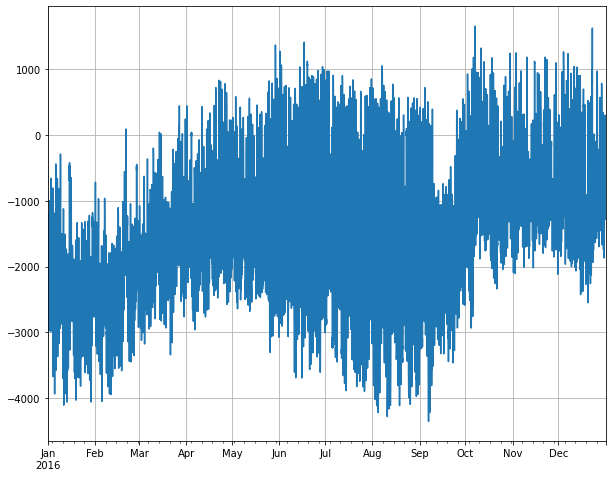

In [6]:
(eastern_demand_2016['MISO'] - miso_subarea_demand.sum(axis=1)).plot(figsize = (10,8), grid=True)

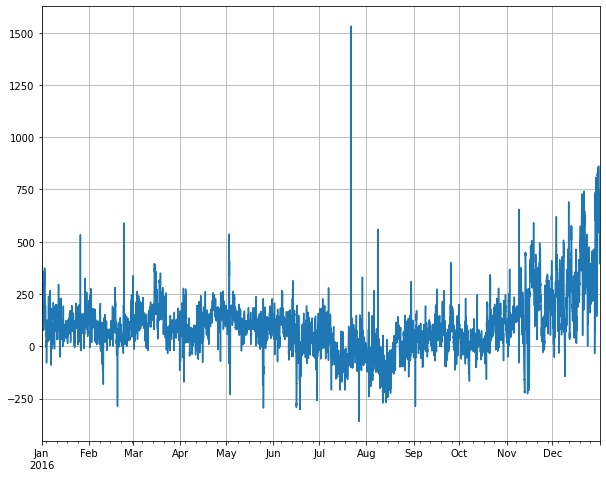

In [7]:
(eastern_demand_2016['SWPP'] - spp_subarea_demand.sum(axis=1)).plot(figsize = (10,8), grid=True)

Follow the profile shape of subarea profile and scale up to match the total absolute value from EIA for each hour.

In [8]:
frac_subarea_miso = miso_subarea_demand.copy()
for zone in miso_subarea_demand.columns:
    frac_subarea_miso[zone] = miso_subarea_demand[zone].divide(
        miso_subarea_demand.sum(axis=1)).multiply(
        eastern_demand_2016['MISO'])

In [9]:
frac_subarea_spp = spp_subarea_demand.copy()
for zone in spp_subarea_demand.columns:
    frac_subarea_spp[zone] = spp_subarea_demand[zone].divide(
        spp_subarea_demand.sum(axis=1)).multiply(
        eastern_demand_2016['SWPP'])

In [10]:
(eastern_demand_2016['SWPP'].sum() - spp_subarea_demand.sum().sum())/spp_subarea_demand.sum().sum()

0.0032739195084063545

In [11]:
(eastern_demand_2016['MISO'].sum() - miso_subarea_demand.sum().sum())/miso_subarea_demand.sum().sum()

-0.021408864093255642

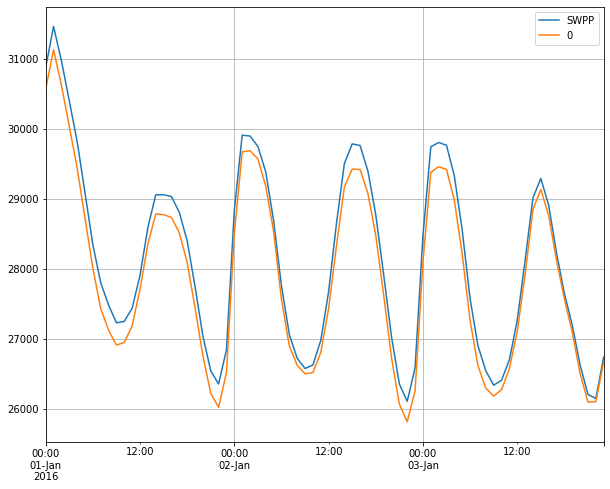

In [12]:
pd.concat([eastern_demand_2016['SWPP'].iloc[:72], 
           spp_subarea_demand.sum(axis=1)[:72]],axis=1).plot(figsize=(10,8), grid=True)

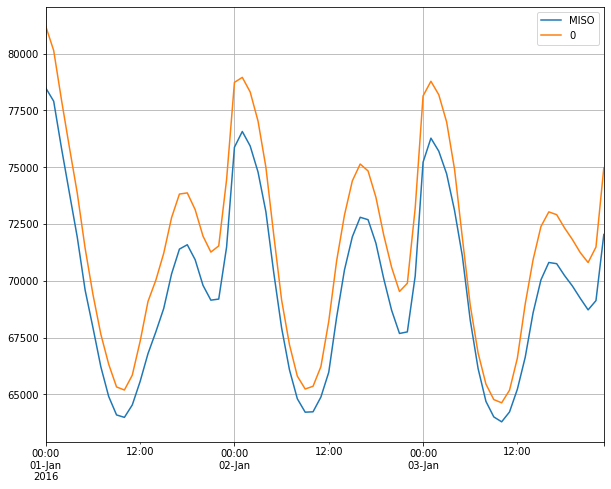

In [13]:
pd.concat([eastern_demand_2016['MISO'].iloc[:72],
           miso_subarea_demand.sum(axis=1)[:72]],axis=1).plot(figsize=(10,8), grid=True)

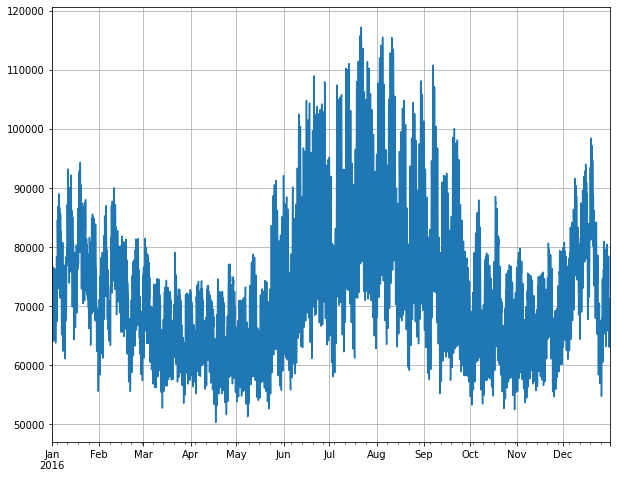

In [14]:
eastern_demand_2016['MISO'].plot(figsize=(10,8), grid=True)

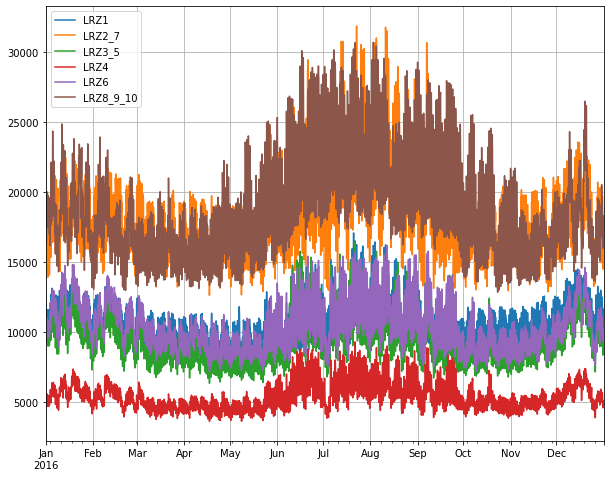

In [15]:
frac_subarea_miso.plot(figsize=(10,8), grid=True)

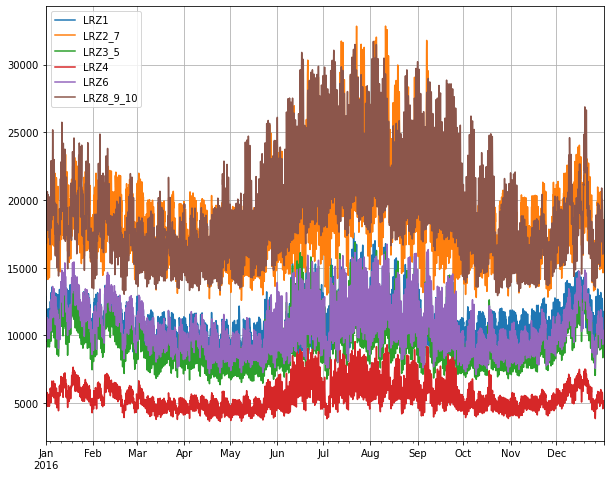

In [16]:
miso_subarea_demand.plot(figsize=(10,8), grid=True)

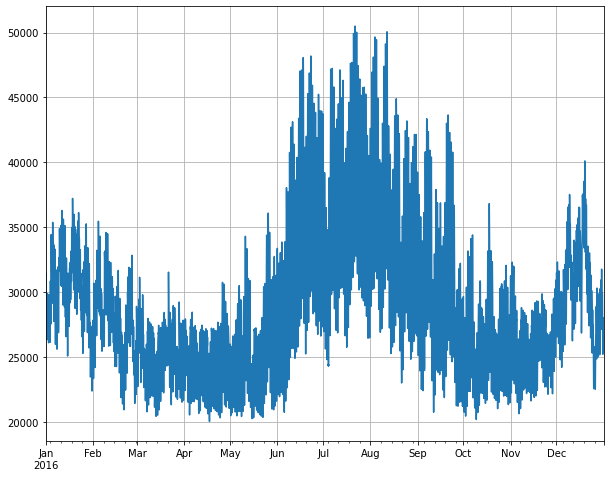

In [17]:
eastern_demand_2016['SWPP'].plot(figsize=(10,8), grid=True)

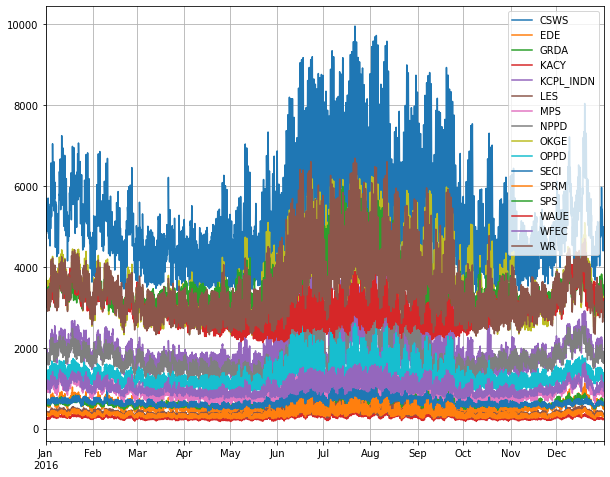

In [18]:
frac_subarea_spp.plot(figsize=(10,8), grid=True)

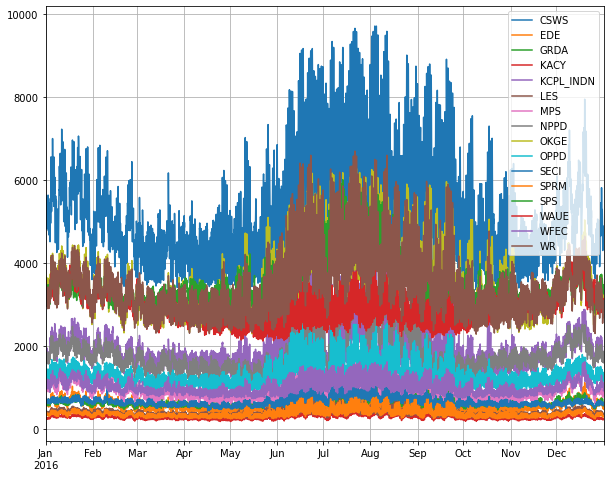

In [19]:
spp_subarea_demand.plot(figsize=(10,8), grid=True)

In [20]:
eastern_demand_2016 = pd.concat([eastern_demand_2016, frac_subarea_miso, frac_subarea_spp], axis=1)

## 4. Aggregate BAs
Some BAs are very small. In these cases, BAs are agregated into BA areas as follows:

In [21]:
ba_area ={
    'ISNE': ['ISNE'],
    'NYIS': ['NYIS'],
    'PJM': ['PJM', 'OVEC'],
    'AEC': ['AEC'],
    'SOCO': ['SOCO'],
    'TVA_LGEE': ['TVA', 'LGEE'],
    'Florida': ['TAL', 'JEA', 'GVL', 'SEC', 'FPC', 'NSB', 'FMPP', 'TEC', 'FPL', 'HST'],
    'AECI': ['AECI'],
    #'MISO':['MISO','AECI'],
    'LRZ1': ['LRZ1'],
    'LRZ2_7': ['LRZ2_7'],
    'LRZ3_5': ['LRZ3_5'],
    'LRZ4': ['LRZ4'],
    'LRZ6': ['LRZ6'],
    'LRZ8_9_10': ['LRZ8_9_10'], 
    #'SWPP':['SWPP','SPA'],
    'CSWS': ['CSWS', 'SPA'],
    'EDE': ['EDE'],
    'GRDA': ['GRDA'],
    'KACY': ['KACY'],
    'KCPL_INDN': ['KCPL_INDN'],
    'LES': ['LES'],
    'MPS': ['MPS'],
    'NPPD': ['NPPD'],
    'OKGE': ['OKGE'],
    'OPPD': ['OPPD'],
    'SECI': ['SECI'],
    'SPRM': ['SPRM'],
    'SPS': ['SPS'],
    'WAUE': ['WAUE'],
    'WFEC': ['WFEC'],
    'WR': ['WR'],

    'Carolina':['CPLW', 'DUK', 'SCEG', 'SC', 'CPLE']
}


In [22]:
eastern_agg_demand = aggregate_ba_demand(eastern_demand_2016, ba_area)
eastern_agg_demand

ISNE regional demand was summed from ['ISNE']

NYIS regional demand was summed from ['NYIS']

PJM regional demand was summed from ['OVEC', 'PJM']

AEC regional demand was summed from ['AEC']

SOCO regional demand was summed from ['SOCO']

TVA_LGEE regional demand was summed from ['LGEE', 'TVA']

Florida regional demand was summed from ['NSB', 'HST', 'FPC', 'GVL', 'TEC', 'FMPP', 'SEC', 'TAL', 'JEA', 'FPL']

AECI regional demand was summed from ['AECI']

LRZ1 regional demand was summed from ['LRZ1']

LRZ2_7 regional demand was summed from ['LRZ2_7']

LRZ3_5 regional demand was summed from ['LRZ3_5']

LRZ4 regional demand was summed from ['LRZ4']

LRZ6 regional demand was summed from ['LRZ6']

LRZ8_9_10 regional demand was summed from ['LRZ8_9_10']

CSWS regional demand was summed from ['CSWS', 'SPA']

EDE regional demand was summed from ['EDE']

GRDA regional demand was summed from ['GRDA']

KACY regional demand was summed from ['KACY']

KCPL_INDN regional demand was summed from ['KCPL_I

,ISNE,NYIS,PJM,AEC,SOCO,TVA_LGEE,Florida,AECI,LRZ1,LRZ2_7,...,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WAUE,WFEC,WR,Carolina
2016-01-01 00:00:00+00:00,16063.0,19726.0,95072.0,492.0,23927.0,23022.0,33518.0,2917.0,12433.625635,18935.912114,...,1935.360424,3680.231068,1531.332910,748.622744,402.975659,3587.312171,3619.588079,1115.993263,3570.464646,22878.0
2016-01-01 01:00:00+00:00,15273.0,19008.0,92298.0,488.0,24347.0,22800.0,31645.0,2946.0,12292.755041,18580.001578,...,1981.483410,3734.738487,1549.895292,764.789182,402.078672,3696.936352,3643.513352,1142.849782,3658.209541,22097.0
2016-01-01 02:00:00+00:00,14568.0,18340.0,89416.0,465.0,23574.0,22258.0,22897.0,2910.0,11892.432899,17939.883463,...,1940.735382,3703.713583,1513.463335,750.701658,390.615840,3674.371288,3582.780463,1148.714183,3582.793021,21357.0
2016-01-01 03:00:00+00:00,13850.0,17557.0,86496.0,444.0,22762.0,21679.0,26967.0,2878.0,11554.337721,17359.510187,...,1898.155404,3648.618172,1474.868777,736.069726,379.830057,3626.131980,3525.447208,1143.648011,3506.871042,20466.0
2016-01-01 04:00:00+00:00,13108.0,16772.0,83405.0,429.0,21857.0,21099.0,25011.0,2829.0,11222.455123,16785.186093,...,1859.707744,3586.621688,1428.755692,722.883309,369.539204,3578.911415,3469.432510,1137.463356,3438.861340,19469.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00+00:00,14716.0,17863.0,89450.0,545.0,26496.0,22763.0,23986.0,2178.0,11555.140115,16780.827347,...,1722.559823,3034.176696,1338.956151,620.102864,305.101268,3443.917807,3054.074604,1009.322626,3036.895677,24925.0
2016-12-31 20:00:00+00:00,14714.0,17847.0,90143.0,528.0,26294.0,22446.0,23906.0,2094.0,11380.473159,16564.999420,...,1666.712374,2976.106884,1305.172117,613.164454,298.563971,3396.262092,2992.807456,970.135985,3008.000103,24653.0
2016-12-31 21:00:00+00:00,14965.0,18117.0,90906.0,513.0,26043.0,22009.0,23985.0,2035.0,11286.898756,16557.182099,...,1624.560920,2918.457277,1278.246278,601.781241,292.655773,3334.248865,2942.657833,940.245899,3009.546624,24634.0
2016-12-31 22:00:00+00:00,15996.0,19122.0,92752.0,521.0,26012.0,22136.0,24431.0,2035.0,11249.867239,16750.864174,...,1612.320901,2878.457610,1261.106738,600.731659,292.674067,3303.890021,2945.258402,924.999762,3050.302626,25303.0


## 5. Detect and Fix Outliers
Indentify and fix outliers. Outliers defined as demand hours for which the ramp rate (difference between two hours) is greater than 3 standard deviations of the ramp rates for the BA across all hours in the year. Demand data for hours identified as outliers are replaced with the average of the neighboring non-outlier hour's demand. Stretches of >5 consecutive outlier hours are flagged.

In [23]:
eastern_fix_outliers = fix_dataframe_outliers(eastern_agg_demand)

1357 104873.0 104873.0
1358 137033.0 104409.0
1359 103945.0 103945.0
2410 19206.0 19206.0
2411 26343.0 19742.0
2412 20278.0 20278.0
701 23378.0 23378.0
702 4517.0 22913.0
703 22448.0 22448.0
7469 16362.0 16362.0
7470 4106.0 15976.0
7471 15590.0 15590.0
8237 25897.0 25897.0
8238 5649.0 25647.5
8239 25398.0 25398.0
8477 28120.0 28120.0
8478 7081.0 27567.5
8479 27015.0 27015.0
1 31645.0 31645.0
2 22897.0 22897.0
1564 18918.0 18918.0
1565 28308.0 18278.0
1566 17638.0 17638.0
1876 31575.0 31575.0
1877 21080.0 21080.0
3412 33165.0 33165.0
3413 23562.0 23562.0
4850 38735.0 38735.0
4851 27638.0 27638.0
6094 42074.0 42074.0
6095 30860.0 30860.0
6171 30200.0 30200.0
6172 21228.0 21228.0
6266 34131.0 34131.0
6267 24657.0 24657.0
6746 26350.0 26350.0
6747 15276.0 15276.0
7195 30944.0 30944.0
7196 41548.0 31338.5
7197 31733.0 31733.0
7633 27013.0 27013.0
7634 15766.0 15766.0
2746 629.6459464821249 629.6459464821249
2747 484.93109968550647 484.93109968550647
3203 695.4946704359145 695.4946704359145


## 6 Get bus to BA area mapping via countyg via county

### A. Create File if not Available
If the file is not available, it will be created by the `bus_ba_map.ipynb` notebook. Note that it takes around 3h to run.

In [24]:
path = os.path.join("..", "eastern_demand_v5_demo")
if not os.path.exists(os.path.join(path, "bus_ba_map.csv")):
    %cd path
    %run ./bus_ba_map.ipynb
    %cd -

### B. Read the Files

In [25]:
bus_map = pd.read_csv(os.path.join(path, "bus_ba_map.csv"), index_col=0)
bus_map_spp = pd.read_csv(os.path.join("spp", "bus_ba_map_spp.csv"), index_col=0)
bus_map_miso = pd.read_csv(os.path.join("miso", "bus_ba_map_miso.csv"), index_col=0)

In [26]:
bus_map_miso['BA'] = bus_map_miso['miso_zone']
bus_map_miso.drop(columns=['miso_zone', 'state'], inplace=True)

In [27]:
no_miso_spp_bus_map = bus_map[~((bus_map['BA'] == 'MISO')|(bus_map['BA'] == 'SWPP'))]

In [28]:
bus_map_new = pd.concat([no_miso_spp_bus_map, bus_map_miso,bus_map_spp]).sort_index()

Transform to load zone using the demand that has missing data filled and outliers fixed, prepared from the first steps in the demo notebook.

In [29]:
final_eastern_demand = get_demand_in_loadzone(eastern_fix_outliers, bus_map_new)

In [30]:
final_eastern_demand.index = final_eastern_demand.index.tz_localize(None)
final_eastern_demand

,Alabama,Florida Panhandle,Arkansas,Illinois Downstate,Missouri East,East Texas,Kansas,Louisiana,Missouri West,Oklahoma,...,Mississippi,New Jersey,Pennsylvania Eastern,Pennsylvania Western,Delaware,Maryland,Virginia Tidewater,West Virginia,New Mexico Eastern,Texas Panhandle
2016-01-01 00:00:00,8786.369603,2197.372586,5644.746112,5228.379425,8291.504918,2106.919642,5866.790904,10101.550890,3165.081880,8062.935551,...,6371.275950,11711.598199,11124.355240,5559.094083,1457.475255,9771.440984,9705.345710,3013.381864,732.581161,2707.404584
2016-01-01 01:00:00,8858.210591,2178.567542,5732.560622,5115.326989,8329.564821,2143.316968,5997.488044,10233.696779,3198.587020,8216.716461,...,6401.191837,11365.838316,10799.704824,5396.817214,1414.949208,9486.330991,9422.164237,2925.457751,754.968009,2790.139790
2016-01-01 02:00:00,8589.958870,1929.228439,5634.815025,4991.177947,8153.308185,2106.183772,5862.632717,10064.351684,3123.339017,8138.584462,...,6275.837637,11008.828130,10462.450517,5228.263066,1370.767497,9190.120825,9127.957674,2834.110493,750.359896,2773.109558
2016-01-01 03:00:00,8310.201108,1975.728787,5528.395836,4848.896786,8000.256007,2067.820159,5729.416035,9863.334033,3053.418440,8032.401664,...,6132.717468,10644.098537,10120.700774,5057.431124,1326.003236,8890.005042,8829.871913,2741.558794,740.508729,2736.702544
2016-01-01 04:00:00,8014.008672,1876.646868,5401.843789,4711.839312,7845.598872,2020.270422,5606.574756,9638.568414,2987.138260,7899.017874,...,5980.800019,10259.253684,9758.957691,4876.617844,1278.617508,8572.313986,8514.329760,2643.587117,730.865605,2701.064393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,9423.810488,2127.906460,5138.198025,4500.053636,6569.884714,1899.856865,5076.063074,9352.500747,2536.373713,6893.368629,...,6100.113413,10999.286349,10466.207126,5229.998786,1371.288724,9193.615323,9131.428536,2835.188149,703.297953,2599.182456
2016-12-31 20:00:00,9323.090728,2113.943916,4982.884025,4450.655715,6382.399489,1840.197680,5001.823905,9086.597367,2475.947747,6701.833079,...,5966.478061,11080.122343,10547.221723,5270.436904,1381.912571,9264.841432,9202.172862,2857.153330,693.565965,2563.215890
2016-12-31 21:00:00,9199.338476,2100.806840,4888.176320,4431.901967,6263.480626,1803.042378,4966.342489,8932.101683,2427.617715,6550.234323,...,5863.243960,11177.281775,10636.551356,5315.109619,1393.609533,9343.262097,9280.063079,2881.337215,680.901965,2516.413468
2016-12-31 22:00:00,9213.946365,2109.431930,4835.070264,4433.252763,6250.194091,1780.748044,4994.418164,8854.133161,2431.608562,6452.669290,...,5847.568144,11422.326718,10852.836341,5423.374035,1421.909131,9532.992828,9468.510447,2939.847638,674.702249,2493.501141


In [31]:
grid = Grid(['Eastern'])
final_eastern_demand.columns = [grid.zone2id[col] for col in final_eastern_demand.columns]
final_eastern_demand = final_eastern_demand.sort_index(axis = 1)
final_eastern_demand

Reading bus.csv
Reading plant.csv
Reading gencost.csv
Reading branch.csv
Reading dcline.csv
Reading sub.csv
Reading bus2sub.csv
Reading zone.csv


,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
2016-01-01 00:00:00,1342.820998,1440.655575,600.763115,7581.562212,910.213388,4209.789191,13681.797134,6569.102877,11711.598199,11124.355240,...,10101.550890,2106.919642,2707.404584,732.581161,8062.935551,5866.790904,4178.705711,2437.353739,2665.475361,203.136725
2016-01-01 01:00:00,1276.779250,1369.802192,571.235771,7208.690759,865.447866,4003.605235,13191.207415,6330.134845,11365.838316,10799.704824,...,10233.696779,2143.316968,2790.139790,754.968009,8216.716461,5997.488044,4252.594903,2436.920886,2668.853159,201.982065
2016-01-01 02:00:00,1217.843260,1306.572273,544.883366,6875.938387,825.498888,3819.512768,12731.366373,6107.739910,11008.828130,10462.450517,...,10064.351684,2106.183772,2773.109558,750.359896,8138.584462,5862.632717,4158.318747,2381.682431,2611.890411,196.427343
2016-01-01 03:00:00,1157.820508,1242.176413,518.037295,6537.050155,784.813262,3631.675821,12197.977055,5847.180918,10644.098537,10120.700774,...,9863.334033,2067.820159,2736.702544,740.508729,8032.401664,5729.416035,4059.325649,2332.503223,2560.658419,191.629369
2016-01-01 04:00:00,1095.791423,1175.628045,490.295684,6186.834183,742.767670,3437.642565,11661.265811,5585.914682,10259.253684,9758.957691,...,9638.568414,2020.270422,2701.064393,730.865605,7899.017874,5606.574756,3957.034582,2284.362759,2510.504880,186.924240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1230.215638,1319.846072,550.369002,6945.792786,833.885340,3856.056040,12429.077975,5949.512441,10999.286349,10466.207126,...,9352.500747,1899.856865,2599.182456,703.297953,6893.368629,5076.063074,3656.677934,2135.770415,2316.966604,183.313214
2016-12-31 20:00:00,1230.048444,1319.666696,550.293181,6944.848807,833.772010,3855.485732,12426.952472,5944.369109,11080.122343,10547.221723,...,9086.597367,1840.197680,2563.215890,693.565965,6701.833079,5001.823905,3554.287676,2097.106652,2274.134372,180.275538
2016-12-31 21:00:00,1251.031328,1342.178341,559.677808,7063.318092,847.994979,3921.137495,12608.057271,6034.159310,11177.281775,10636.551356,...,8932.101683,1803.042378,2516.413468,680.901965,6550.234323,4966.342489,3472.588670,2069.170994,2242.228215,178.342143
2016-12-31 22:00:00,1337.219989,1434.646491,598.217981,7549.938937,906.416818,4190.452183,13270.892083,6368.153248,11422.326718,10852.836341,...,8854.133161,1780.748044,2493.501141,674.702249,6452.669290,4994.418164,3440.171537,2067.451327,2241.208701,177.973460


In [32]:
print(final_eastern_demand.columns)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52],
           dtype='int64')


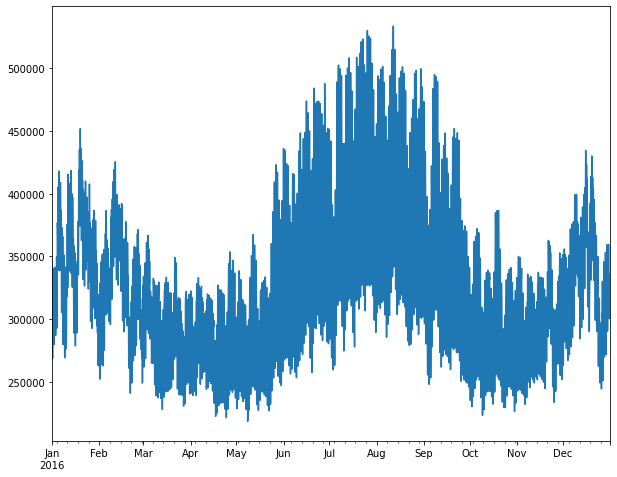

In [33]:
final_eastern_demand.sum(axis=1).plot(figsize=(10,8))

In [34]:
final_eastern_demand.index.name = "UTC Time"
final_eastern_demand.to_csv("eastern_demand_v6.csv")